In [1]:
%load_ext autoreload
%autoreload 2

# Simple example CBPS using Lalonde

In [2]:
import sys
sys.path.append("..")

from src.cbps_torch import CBPS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read lalonde data
df = pd.read_csv("data/lalonde_psid.csv")
df.head()

,age,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75,treat
0,37,11,1,0,1,1,0.0,0.0,9930.05,1,1,1
1,22,9,0,1,0,1,0.0,0.0,3595.89,1,1,1
2,30,12,1,0,0,0,0.0,0.0,24909.50,1,1,1
3,27,11,1,0,0,1,0.0,0.0,7506.15,1,1,1
4,33,8,1,0,0,1,0.0,0.0,289.79,1,1,1


In [4]:
w, y = df.treat.values, df.re78.values
X = df.drop(columns=["treat", "re78"]).values
X = MinMaxScaler().fit_transform(X)

In [5]:
print(
    f" Our effect benchmark is given by: {y[w == 1].mean() - y[w == 0].mean()}"
)

 Our effect benchmark is given by: -15204.775555988717


## Experiments with dimensionality reduction and playing with other parameters

In [6]:
cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10000,
    lr=1e-2,
    reg=1e-5,
    svd=None,
)
weights = cbps.weights

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:03<00:00, 3140.49it/s]


In [23]:
y[w == 1].mean() - np.average(y[w == 0], weights=cbps.weights.detach().numpy())

2425.740840624178

<AxesSubplot: xlabel='Standardized Differences', ylabel='Variables'>

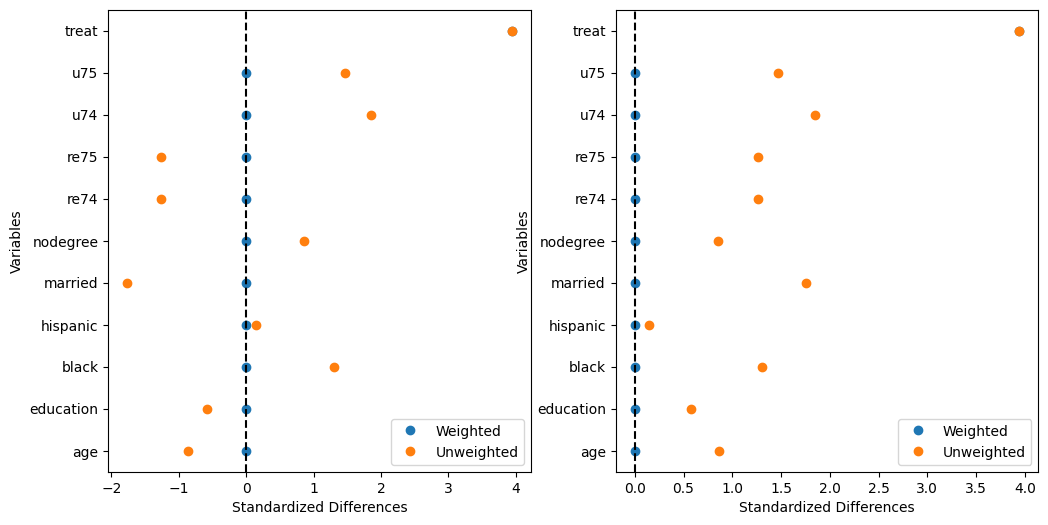

In [24]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
cbps.diagnose(method="smd", ax = ax[0])
cbps.diagnose(method="asmd", ax = ax[1])

## High Dimensional Case

In [25]:
from sklearn.preprocessing import PolynomialFeatures
w, y = df.treat.values, df.re78.values
X = df.drop(columns=["treat", "re78"]).values
X = MinMaxScaler().fit_transform(X)
X = PolynomialFeatures(degree=2).fit_transform(X)

In [30]:
cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10_000,
    lr=1e-2,
    reg=1e-5,
    svd=None,
)
weights = cbps.weights

Optimizing CBPS...:   0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:04<00:00, 2036.47it/s]


In [31]:
y[w == 1].mean() - np.average(y[w == 0], weights=cbps.weights.detach().numpy())

2174.1325054064027

<AxesSubplot: xlabel='Unweighted Standardized Differences', ylabel='Weighted Standardized Differences'>

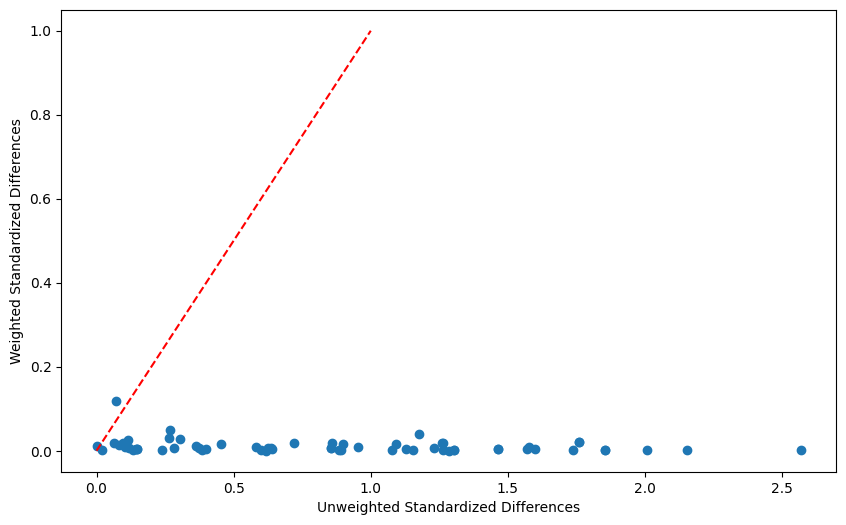

In [32]:
cbps.diagnose(method="asmd", scatter = True)

### Or with columns names if using a pandas dataframe

Optimizing CBPS...: 100%|██████████| 10000/10000 [00:05<00:00, 1898.02it/s]


<AxesSubplot: xlabel='Standardized Differences', ylabel='Variables'>

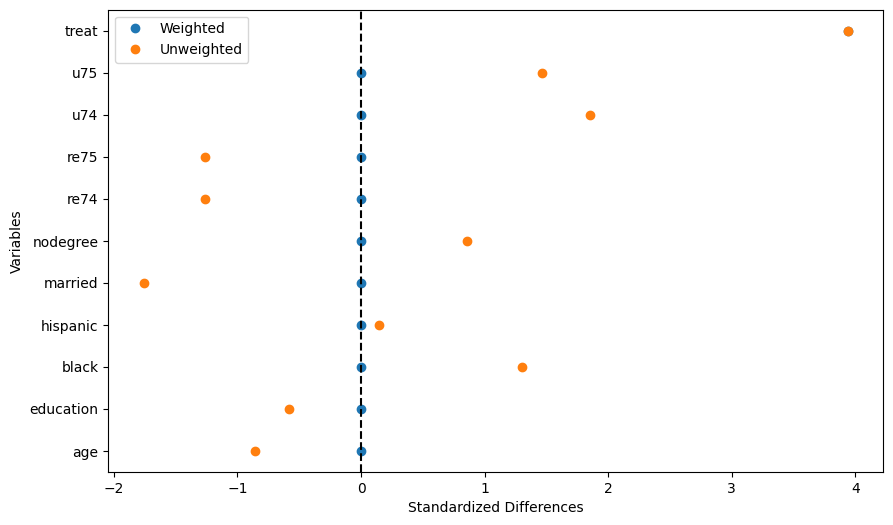

In [9]:
cbps = CBPS(
    X=df.drop(columns=["re78"]),
    W="treat",
    estimand="ATT",
    intercept=True,
    noi=False,
    niter=10000,
    lr=1e-2,
    reg=1e-5,
    svd=None,
)
cbps.diagnose(method="smd")

<AxesSubplot: xlabel='Standardized Differences', ylabel='Variables'>

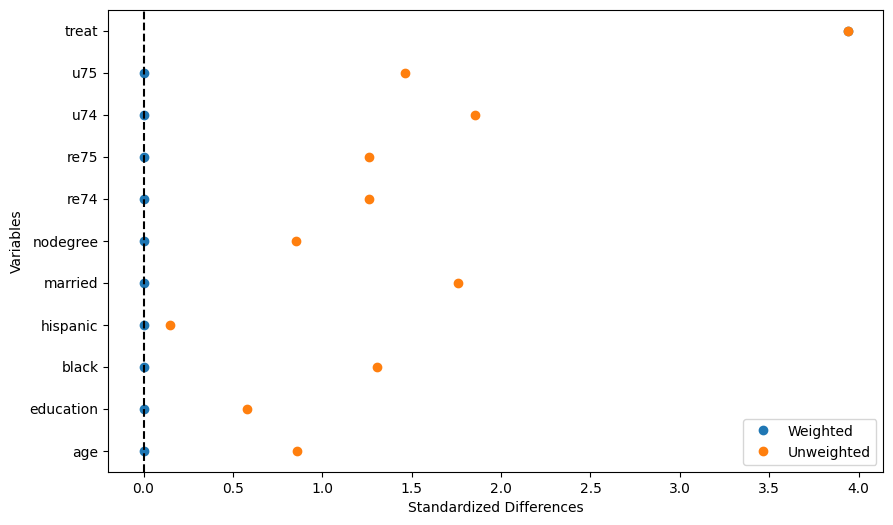

In [10]:
cbps.diagnose(method="asmd")